In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
from natsort import natsorted

In [2]:
# Dataset

In [217]:
data_dir = "C:/Users\carly/OneDrive/Extend AI/extend-ai-ml-assessment-main/extend-ai-ml-assessment-main/data"

transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])

# Data Augmentation
#torchvision_transform = transforms.Compose([
#    transforms.Resize((x, y)), 
#    transforms.RandomCrop(512),
#    transforms.RandomHorizontalFlip(),
#    saturation, contrast, etc.
#    transforms.ToTensor(),
#])

In [218]:
# Define own class LoadFromFolder

class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
         
        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
        
    def __len__(self):
        # Return the previously computed number of images
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])

        # Use PIL for image loading
        image = Image.open(img_loc).convert("L")
        # Apply the transformations
        tensor_image = self.transform(image)
        return tensor_image

In [219]:
dataset = LoadFromFolder(main_dir=data_dir, transform=transform)
loader = DataLoader(dataset)
print(next(iter(loader)).shape)  # prints shape of image with single batch

torch.Size([1, 1, 512, 512])


torch.Size([512, 512])


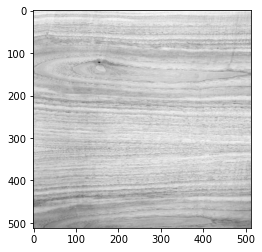

In [221]:
sample = next(iter(loader))
len(sample)

image = sample
type(image)
image.shape
print(image.squeeze().shape)

plt.imshow(image.squeeze(), cmap="gray")

In [222]:
len(iter(loader)) # 7 - augment data using transforms

7

In [237]:
# Training and Test Set

fullset = torch.utils.data.DataLoader(
    dataset, batch_size=1
)
# if batch_size 2, len 4

training_set, test_set = random_split(fullset.dataset, [4, 3], generator=torch.Generator().manual_seed(42))

In [238]:
print(len(fullset))
print(len(training_set))
print(len(test_set))

7
4
3


In [281]:
trainloader = DataLoader(training_set, batch_size=1)
trainsample = next(iter(trainloader))
trainsample.shape

torch.Size([1, 1, 512, 512])

In [ ]:
# Model

# CITE https://github.com/msminhas93/anomaly-detection-using-autoencoders/blob/master/model.py

# input 1 channel
# input/output size 512*512

In [240]:
class AnomalyAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 48, (11, 11), stride=(1, 1), padding=5)
        self.bn1 = nn.BatchNorm2d(48)

        self.conv2 = nn.Conv2d(48, 48, (9, 9), stride=(2, 2), padding=4)
        self.bn2 = nn.BatchNorm2d(48)

        self.conv3 = nn.Conv2d(48, 48, (7, 7), stride=(2, 2), padding=3)
        self.bn3 = nn.BatchNorm2d(48)

        self.conv4 = nn.Conv2d(48, 48, (5, 5), stride=(2, 2), padding=2)
        self.bn4 = nn.BatchNorm2d(48)

        self.conv5 = nn.Conv2d(48, 48, (3, 3), stride=(2, 2), padding=1)
        self.bn5 = nn.BatchNorm2d(48)

        self.conv_tr1 = nn.ConvTranspose2d(
            48, 48, (5, 5), stride=(2, 2), padding=2, output_padding=1)
        self.bn_tr1 = nn.BatchNorm2d(48)

        self.conv_tr2 = nn.ConvTranspose2d(
            96, 48, (7, 7), stride=(2, 2), padding=3, output_padding=1)
        self.bn_tr2 = nn.BatchNorm2d(48)

        self.conv_tr3 = nn.ConvTranspose2d(
            96, 48, (9, 9), stride=(2, 2), padding=4, output_padding=1)
        self.bn_tr3 = nn.BatchNorm2d(48)

        self.conv_tr4 = nn.ConvTranspose2d(
            96, 48, (11, 11), stride=(2, 2), padding=5, output_padding=1)
        self.bn_tr4 = nn.BatchNorm2d(48)

        self.conv_output = nn.Conv2d(96, 1, (1, 1), (1, 1))
        self.bn_output = nn.BatchNorm2d(1)

    def forward(self, x):
        slope = 0.2
        x = F.leaky_relu((self.bn1(self.conv1(x))), slope)
        x1 = F.leaky_relu((self.bn2(self.conv2(x))), slope)
        x2 = F.leaky_relu((self.bn3(self.conv3(x1))), slope)
        x3 = F.leaky_relu((self.bn4(self.conv4(x2))), slope)
        x4 = F.leaky_relu((self.bn5(self.conv5(x3))), slope)

        x5 = F.leaky_relu(self.bn_tr1(self.conv_tr1(x4)), slope)
        x6 = F.leaky_relu(self.bn_tr2(
            self.conv_tr2(torch.cat([x5, x3], 1))), slope)
        x7 = F.leaky_relu(self.bn_tr3(
            self.conv_tr3(torch.cat([x6, x2], 1))), slope)
        x8 = F.leaky_relu(self.bn_tr4(
            self.conv_tr4(torch.cat([x7, x1], 1))), slope)

        output = F.leaky_relu(self.bn_output(
            self.conv_output(torch.cat([x8, x], 1))), slope)
        return output

if __name__ == "__main__":
    x = torch.rand([1,1,512,512])
    model = AnomalyAE()
    y = model(x)
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)

torch.Size([1, 1, 512, 512]) torch.float32
torch.Size([1, 1, 512, 512]) torch.float32


torch.Size([1, 1, 512, 512])
torch.Size([512, 512])


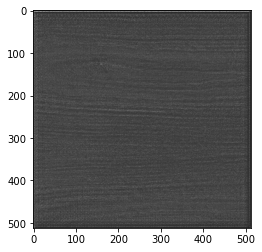

In [241]:
sampleoutput=model(sample)
print(sampleoutput.shape)
print(sampleoutput.squeeze().shape)
sampleshow=sampleoutput.squeeze()
plt.imshow(sampleshow.detach().numpy(), cmap="gray")

In [272]:
# Train

model = AnomalyAE()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 2
outputs = []
for epoch in range(num_epochs):
    for img in trainloader:
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.4624
Epoch:2, Loss:0.4350


In [279]:
# Only getting recon of 1 image?

#for img in trainloader:
#    print('1')

#len(recon)

# ISSUE TO FIX - something to do with batch size?

1
1
1
1


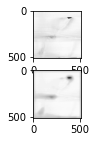

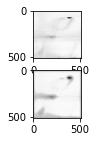

In [265]:
# Plot images

for k in range(0, num_epochs):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i>= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon):
        if i>= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])      
        
# We see that our CNN model is too sensitive - we are picking up other dark pattern, whereas the original shows stronger knot isolation

In [ ]:
# Still some work to do:
# * bug fixes
# * data augmentation
# * model optimization & futher training
# * properly displaying segmentation/anomoly detection
    # see e.g. here: https://github.com/msminhas93/anomaly-detection-using-autoencoders/blob/master/Results.ipynb
# * always nice to have a summary of results!